# Let's see who's down at the Rec Center

A demographic analysis of users of the Recreation Center network in Boulder Colorado, along with the membership packages they use (or do not use) to access the network.

![](pool.jpg)  

Data is a public dataset available [here](https://open-data.bouldercolorado.gov/datasets/121a6643af894314bd02ea42544ce9d9_0).

The data dictionary is available [here](https://webappsprod.bouldercolorado.gov/opendata/rec_center_customer_demographics_data_dictionary.csv) and reprinted below.

|Column Name|Description|
|:-----|:-----|
|geographic_area_id|Two options, Resident and Nonresident.  Resident equals patron lives within the city of Boulder Boundaries and received the discounted resident rate for memberships and activities.  Nonresident identified patrons outside the city boundaries.|
|city|City which patron resides in|
|state|State patron resides in|
|zipcode|Zip code patron resides in|
|age|Age (in years) of customer at the time of calculation and publishing. Calculated by subtracting the year of birth from 2017. 'n/a' values indicate the birthdate was blank in the system.|
|entrydate|Date patron used membership to enter facility|
|gender|Gender identified by patron|
|resident|In reference to geographic area, if resident field equals yes, if nonresident field equals no|
|retired|Patrons account is no longer active in our database|
|Package1|First type membership patrons has been assigned or purchased|
|Package2|Additional type of membership patrons has been assigned or purchased|
|Package3|Additional type of membership patrons has been assigned or purchased|
|Package4|Additional type of membership patrons has been assigned or purchased|
|Package5|Additional type of membership patrons has been assigned or purchased|
|Package6|Additional type of membership patrons has been assigned or purchased|
|Package7|Additional type of membership patrons has been assigned or purchased|


## Key Questions:
  
1.  Are there any groups who seem to be missing in the demographics of Rec Center customers?  
  
  
2.  What types of packages are most commonly purchased by customers of the Rec Center, and how popular are they?  
    
    
3.  Are there trends in the kind of packages are purchased by certain customers?  Could machine learning be helpful in identifying which packages might appeal to which customers?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns; sns.set_theme()
import re
import zipcodes
from geopy.distance import geodesic
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

pal = sns.color_palette()
sns.set_context('talk')

The dates are in the form _31-Dec-99_ and so we need to pass an appropriately configured datetime parser to the `pd.read_csv()` method.

In [2]:
dateparser = lambda x: pd.to_datetime(x, format="%d-%b-%y",errors='coerce')
demo = pd.read_csv('Demographics_of_Parks_and_Recreation_Center_Customers.csv', 
                   parse_dates=['entrydate'], 
                   date_parser=dateparser,
                   low_memory=False)
print("Shape of dataframe:", demo.shape)
demo.head()

Shape of dataframe: (93581, 17)


,ObjectId,geographic_area_id,city,state,zipcode,age,entrydate,gender,resident,retired,Package1,Package2,Package3,Package4,Package5,Package6,Package7
0,1,Non Resident,Lafayette,CO,80026,59.0,2015-01-02,Male,No,No,ADULT: Passport Pass - 10 Punch Card,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Resident,Boulder,CO,80304,16.0,2004-05-05,Male,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Resident,Boulder,CO,80304,NaN,2006-05-17,Male,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Resident,Boulder,CO,80304,NaN,2001-02-12,Female,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Resident,Boulder,CO,80304,13.0,2006-05-17,Female,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data and Business Understanding

The City of Boulder Recreation network consists of three centers: South, North and East Boulder Rec Centers.  In addition, the Boulder Reservoir (or Rez) falls under the umbrella.

All three have pools, exercise equipment, and gym space as well as offer different types of classes.  They can generally be thought of as gyms/workout facilities, but as the name implies many customers use them for pure recreation as well as fitness.

In [3]:
print("Percent null values in columns:")
demo.isna().sum()/demo.shape[0]*100

Percent null values in columns:


ObjectId               0.000000
geographic_area_id     0.000000
city                   0.000000
state                  0.000000
zipcode                0.000000
age                   19.741187
entrydate              0.007480
gender                 0.000000
resident               0.000000
retired                0.000000
Package1              70.652162
Package2              92.474968
Package3              98.254988
Package4              99.581112
Package5              99.902758
Package6              99.976491
Package7              99.997863
dtype: float64

In general, the data is well-populated.  Only 19% of entries are missing the age field, and less than 1% are missing an entry date.  The NaNs in the 'PackageX' fields are not truly missing data.  NaN in the Package1 field means that the customer did not purchase a bulk package (membership, punch card, or other type of pass).  The Package2-5 fields represent additional possible purchases and as the %NaN is monotonically increasing we can see it appears to be well-behaved.

As a result, we will _drop_ rows missing an entry date, and attempt to _work around_ the rows with missing ages.

In [4]:
demo = demo[pd.notnull(demo['entrydate'])]

So what are these packages?  Let's take a look at a few of them.

In [5]:
demo['Package1'].unique().tolist()[20:26]

['SENIOR: Passport Pass - Annual Membership',
 'FAMILY: Summer Splash Pass - Passport',
 'SilverSneakers Tracking Membership',
 'ADULT: Passport Pass - Annual Membership',
 'YOUTH: Passport Pass - 40 Punch Card',
 'CHILD CARE: 90 Minute Pass - 10 Punch Card']

Looks like they break down primarily into **Punch Cards** and **Memberships**.

To confirm this is the primary breakdown across the dataset and across the different `PackageXX` columns, let's look at the word frequency.

In [6]:
# first bring all the package columns together into one
demo['Packages'] = ""
for col in ['Package1', 'Package2', 'Package3', 'Package4', 'Package5', 'Package6', 'Package7']:
    demo['Packages'] += " " + demo[col].astype(str)
print(demo.loc[0,'Packages'])

 ADULT: Passport Pass - 10 Punch Card nan nan nan nan nan nan


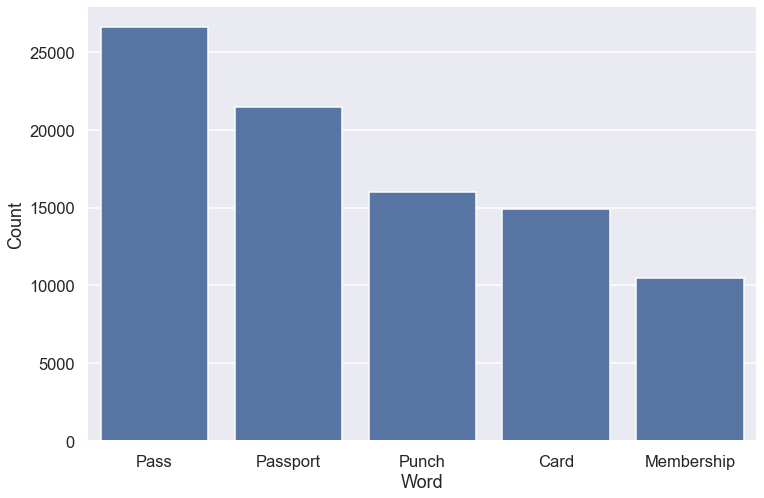

In [7]:
f, ax = plt.subplots(figsize=(12,8))
from collections import Counter
# bring it all into a single list
pkgs_list = demo['Packages'].tolist()
# remove the word "nan" so it does not dominate
pkgs_list = [re.sub("nan","",x).strip() for x in pkgs_list]
# remove the prefix (e.g. ADULT: or SENIOR:) to focus on the type of package
pkgs_list = [re.sub("[A-Z]+:\s?","",x).replace("- ", "") for x in pkgs_list if x != ""]
# join it all into a single string, then split by word (where before was split by row in the data)
words = " ".join(pkgs_list).split(" ")
c = Counter(words)
c_df = pd.DataFrame(c.most_common(5),columns=['Word','Count'])
sns.barplot(data=c_df, x='Word',y='Count',color=pal[0], ax=ax);

So it looks like we have a lot of occurrences of `Passport Pass` (while Pass may occur in other rows, since it occurs more frequently than Passport) as well as `Punch Card` and `Membership`.  We know even from the cursory look that `Passport Pass` can refer to a punch card or a membership, so it appears the primary division of Punch Card vs Membership is valid.

Circling back to the entry date.  That is a bit of a mystery - this is billed as a demographic dataset.  Dates usually do not enter into the equation.  

The data dictionary explains `entrydate` with:  **_Date patron used membership to enter facility_** 

This is not particularly illuminating.  There are 3 possible interpretations of `entrydate` in this context, all of which pertain to different views of what constitues a row in this database:

1. Each row is a unique **customer**.  `entrydate` is the date the customer was first entered in the system.  The packages refer to the memberships purchased as of the export date.  
  
  
2. Each row is a unique **customer/package combination**.  `entrydate` is the first date each customer/package combination appears.  If a customer later purchases a different package or a package lapses, they will appear again in the database with the new combination.  
  
  
3. Each row is a unique **entry into the facility**.  `entrydate` is the date of that entry, and the packages listed are the ones purchased by the customer as-of that date.  Every time a customer visits the rec center, that will appear again in the database with a new date and new packages (if applicable).  

So let's take a closer look at the entry date:

In [8]:
end = demo['entrydate'].max()
start = demo['entrydate'].min()
print("Range:",start, end)

Range: 1988-01-20 00:00:00 2018-01-09 00:00:00


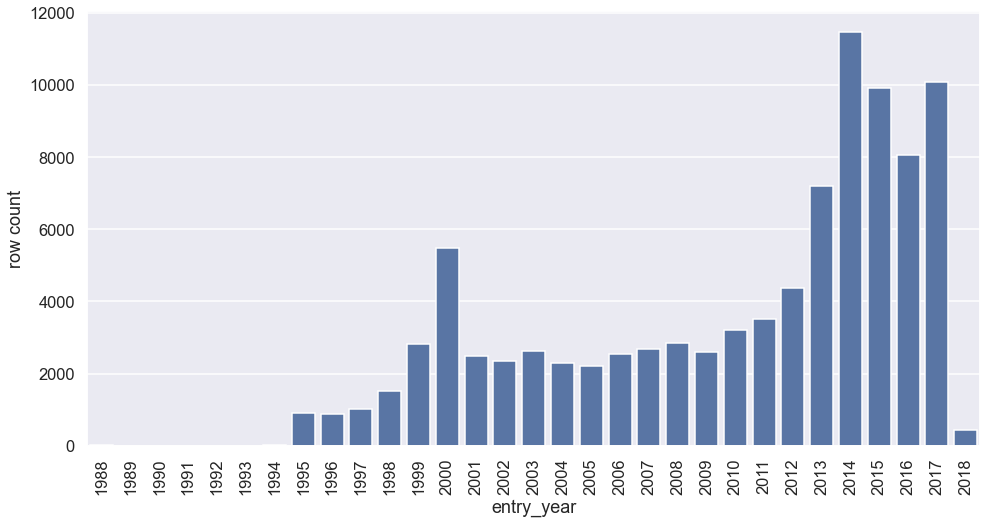

In [9]:
f, ax = plt.subplots(figsize=(16,8))
entries = demo.groupby(pd.Grouper(key='entrydate',freq='Y')).count()['ObjectId'].reset_index()
entries['entry_year'] = entries['entrydate'].dt.strftime('%Y')
sns.barplot(data=entries,x='entry_year',y='ObjectId', ax=ax, color=pal[0])
ax.set(xlabel='entry_year',ylabel='row count')
ax.tick_params(axis='x',rotation=90);

While the first entry is officially in 1988, the data properly starts in 1995.  This is also an indication that options 3 and 2 above are unlikely.  The Boulder metro area has a population of over 300,000 residents, and the likelihood of only 10,000 total visits to the rec center over a year is very low.

Let's look more in depth at possibility 3 above, where each row represents a unique facility entry.  If that were the case, we would expect certain repeating patterns in the dataset.  The same collection of information (age, zip, gender, resident status, package purchase) would tend to appear more than once on different dates as people return and use the rec center multiple times.  For many customers, this would overlap.  Does this occur?

First, we'll create a column that combines all the unique customer-level attributes.  This is essentially everything other than the date.

In [10]:
# get list of all the columns in the dataset we would expect to repeat with each different entry by the same person
# we need to remove objectID (always would be unique) and entrydate
cols_2 = demo.columns.tolist()
cols_2.remove('ObjectId')
cols_2.remove('entrydate')
cols_2.remove('Packages')
print("Columns in dataset: ",cols_2)

# Generate a column which pulls all the elements of each record into a single column
demo.loc[:,'everything'] = ""
for col in cols_2:
    demo.loc[:,'everything'] = demo.loc[:,'everything'] + "-" + col + ":" + demo.loc[:,col].astype(str)
print()
print("Example of column with all data pulled into it:")
demo.loc[1,'everything']

Columns in dataset:  ['geographic_area_id', 'city', 'state', 'zipcode', 'age', 'gender', 'resident', 'retired', 'Package1', 'Package2', 'Package3', 'Package4', 'Package5', 'Package6', 'Package7']

Example of column with all data pulled into it:


'-geographic_area_id:Resident-city:Boulder-state:CO-zipcode:80304-age:16.0-gender:Male-resident:Yes-retired:No-Package1:nan-Package2:nan-Package3:nan-Package4:nan-Package5:nan-Package6:nan-Package7:nan'

Next, we will look at how many times those collections of attributes occur across the dataset, focusing on those who bought memberships.

In [11]:
# Let's look just at the membership purchasers - create column indicating if person has a membership
demo['Membership'] = demo['Packages'].map(lambda x: 'Membership' in x if pd.notnull(x) else False)
# Group the dataframe by all the unique attributes, and see how many times those attributes appear
counts = demo[demo.Membership].groupby(['everything']).size().reset_index(name='Count')
# Show results as a fraction
counts['Count'].value_counts().sort_index() / counts['Count'].value_counts().sum()

1     0.860336
2     0.089274
3     0.026848
4     0.009126
5     0.005687
6     0.002381
7     0.002381
8     0.001587
9     0.000265
10    0.000265
11    0.000265
12    0.000265
13    0.000265
14    0.000265
15    0.000132
16    0.000132
17    0.000132
19    0.000132
26    0.000132
51    0.000132
Name: Count, dtype: float64

So let's think back to option 3, wheree very row in the database is a unique entry to the factility.  If that's the case, this would mean 85% of membership purchasers visited only once, and over 95% of membership purchasers visited 2 or less times.  I know it's hard to keep new year's resolutions, but that seems a bit far-fetched.  It's far more likely that the multiple combinations we see in the dataset are different people who have the same set of characteristics.  So we can safely discard option 3.

What about option 2, where each entry is a unique customer/package combination?  A similar analysis can be applied, just with a slightly different flavor.

In [12]:
cols_3 = cols_2.copy()
for col in ['Package1', 'Package2', 'Package3', 'Package4', 'Package5','Package6','Package7']:
    cols_3.remove(col)
print("Columns to investigate for option 2:",cols_3)

# Generate a column which pulls all the elements of each record into a single column
demo.loc[:,'most_things'] = ""
for col in cols_3:
    demo.loc[:,'most_things'] = demo.loc[:,'most_things'] + "-" + col + ":" + demo.loc[:,col].astype(str)
print()
print("Example of column with all non-package purchase data pulled into it:")
demo.loc[1,'most_things']

Columns to investigate for option 2: ['geographic_area_id', 'city', 'state', 'zipcode', 'age', 'gender', 'resident', 'retired']

Example of column with all non-package purchase data pulled into it:


'-geographic_area_id:Resident-city:Boulder-state:CO-zipcode:80304-age:16.0-gender:Male-resident:Yes-retired:No'

To limit this analysis, we will look at rare zip codes - zip codes which appear only once in the dataset.  First let's count them up.

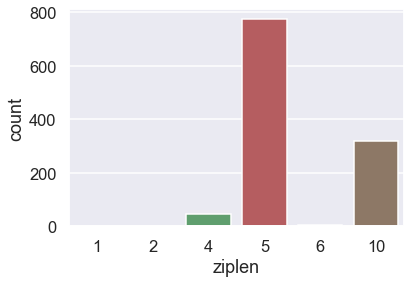

In [13]:
zips = demo['zipcode'].value_counts().reset_index()
zips.columns = ['zipcode','count']
zips['ziplen'] = zips['zipcode'].apply(len)
sns.countplot(data=zips,x='ziplen');

Some of these zipcodes look bogus, since zips are either 5 or 10 characters in length.  For now we will limit this analysis to the zipcodes with 5-digit zipcodes and clean the rest up later.

In [14]:
# limit to 5-digit zipcodes (some zipcodes in dataset are 9-digit and some are just the 4-digit suffix)
zips = zips[zips.ziplen == 5]
rarezips = zips[zips['count'] == 1]
print("Number of rare zip codes:", rarezips.shape[0])

Number of rare zip codes: 446


In [15]:
demo[demo.zipcode.isin(rarezips['zipcode'])]['Package1'].fillna("No Package").value_counts()

No Package                                            340
ADULT: Passport Pass - 10 Punch Card                   30
SENIOR: Passport Pass - 10 Punch Card                  11
ADULT: Passport Pass - 1 Month Membership              11
ADULT: Well-being@Work! - Annual Membership             9
REZ:Small Water Craft-Plus Admissions                   7
SilverSneakers Tracking Membership                      4
ADULT: Summer Membership - BAM Contract Groups          4
ADULT: Passport Pass - 20 Punch Card                    3
ADULT: Seasonal Employee Pass - Passport Pass           2
Summer Camp ID Card                                     2
ADULT: 28 Days for $28 Dollars                          2
ADULT: Fall into Fitness - $99 Unlimited Pass           2
SR Parking Permit                                       2
ADULT: Punch (annual) Membership - BAM Contract         2
ADULT: Twilight Pass - Annual Membership                2
ADULT: Financial Aid Approved - Entry Fee Discount      2
ADULT: BAM Con

Recall option 2 - each entry is a unique **customer/package combination**.  Of these 446 visitors from unique zip codes, many purchased different types of packages.  Some punch cards, 1-month memberships.  Some even annual memberships!

For option 2 to be the case, all of these visitors would have to always enter with the exact same package combination every time they visit.  No single-visit (non-package) purchasers would ever buy a punch card.  No punch-card purchaseres would ever pay-as-they-go.  Already seems unlikely, but let's take a bit more of a look at the time of year these customers visit.

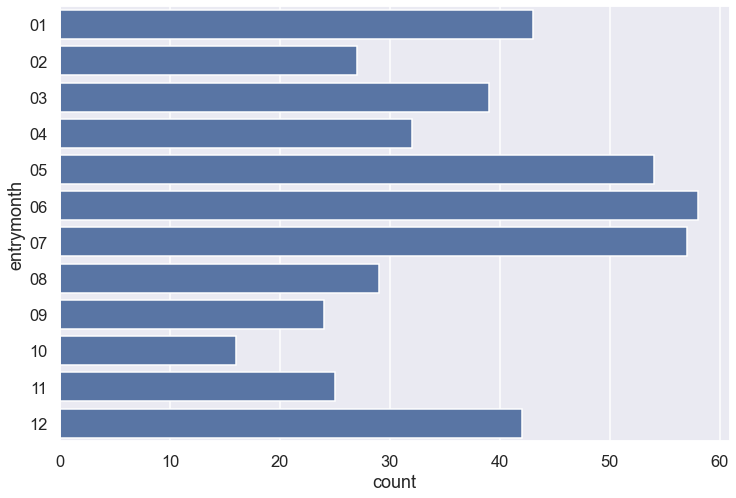

In [16]:
demo['entrymonth'] = demo['entrydate'].dt.strftime('%m')

# Initial entry month of out-of-town visitors
f, ax = plt.subplots(figsize=(12,8))
order = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
sns.countplot(data=demo[demo.zipcode.isin(rarezips['zipcode'])],y='entrymonth',ax=ax, order=order, color=pal[0]);

Looking at the entry date of these rare-zip visitors, there is a strong seasonality to it - people visiting over the summer or over end-of-year holidays.  The end-of-year holidays especially strongly imply these are people returning from across the country to visit family.  As a result, the likelihood of their always entering on the same package purchase is even lower.

While less convincing than our case against option 3, we will use this justification to discard option 2.  This leaves us with option 1:

1. Each row is a unique **customer**.  `entrydate` is the date the customer was first entered in the system.  The packages refer to the memberships purchased as of the export date.  
  

In this way, `entrydate` is better understood as the length of time someone has been a customer, such as a "member since" stamp on a credit card or a measure of customer loyalty.  With that understood, let's take a more serious look at the data.

## Data Preparation

The structure of the `PackageXX` columns is quite clumsy and complicates our analysis.  Since people may buy so may different types of packages, we want to process them into groups of one-hot type encodings.  Did someone buy a membership?  Did someone buy a punchcard?  What type of membership/punch did they get?

As a result, we need to process the groups of packages into these boolean variables.  We already created a `Packages` column which concatenates all packages into one row for easier analysis.  So we will reuse that again to process different package types.

In [17]:
# Need to turn the list of all packages into some key boolean data about them
# Is the type of pass ADULT, SENIOR, FAMILY, REZ or YOUTH (all prefixes that usually occur)
# at the beginning of the package decription (e.g. YOUTH: Passport Pass - 40 Punch Card)
#
# And we would also like to know if a `Membership` or `Punch` Card is among the packages.
#
# Iterate through the list of search terms in the package field
for searchthing in ['ADULT', 'SENIOR', 'FAMILY', 'REZ', 'YOUTH', 'Membership', 'Punch', 'Season']:
    # create a new column for each search term, based on whether that term appears in the column with all packages
    demo[searchthing.lower().capitalize()] = demo['Packages'].map(lambda x: searchthing in x)
# also helpfup to know whether someone bought a package at all or not - create that based on na values in Package1
demo['bought_package'] = demo['Package1'].notna()
print(demo.loc[0])

ObjectId                                                              1
geographic_area_id                                         Non Resident
city                                                          Lafayette
state                                                                CO
zipcode                                                           80026
age                                                                59.0
entrydate                                           2015-01-02 00:00:00
gender                                                             Male
resident                                                             No
retired                                                              No
Package1                           ADULT: Passport Pass - 10 Punch Card
Package2                                                            NaN
Package3                                                            NaN
Package4                                                        

In addition, we learned earlier that `entrydate` is really more of a customer loyalty element.  So we should calculate that too to bring into the analysis.

In [18]:
demo['years_of_membership'] = 2018 - demo['entrydate'].dt.strftime('%Y').astype('int')

In [19]:
# to analyze the age, need to create a binned column for histograms
# create 5-year bins using np.arange
bins=np.arange(0,demo['age'].max()+5,5)
# create the labels for the bins
labels=[str(bin) for bin in bins[1:].tolist()]
# create binned column using the bins and labels with pd.cut
demo['age_binned'] = pd.cut(demo['age'], bins=bins, labels=labels)

Finally, we need to clean up the zip code issues we noticed from before.  A 4-digit zip code addendum is not much use, since we would need to know which 5-digit precedes it.  So they must be treated for now as `NaN`.

In [20]:
# this cell can take a very long time to run - it is looking up lat-longs for 90,000 zip codes, 
# then calculating point-to-point distances for all of them.
demo['zipcode'] = demo['zipcode'].apply(lambda x: x if len(x) in [5, 10] else np.nan)

Zipcodes themselves are not much use.  But they can provide potentially useful distance information, which is finer-grained than city/state, and also has the advantage of being continuous vs categorical information.  So let's calculate the distance in km between each zipcode and a base zipcode in the center of Boulder.

In [21]:
base_zip = '80310'
# function to determine the lat/long associated with a zipcode using the zipcodes package
latlong = lambda x: (float(zipcodes.matching(str(x))[0]['lat']), float(zipcodes.matching(str(x))[0]['long']))
# get latlong of base zip code
base_zip_coords = latlong(base_zip)
# define function to get distance to base zip code
def distance_to_base_zip_km(x, base_coords):
    """
    Returns distance in km from a zip code to a set of base coordinates.
    Gracefully handles input of NaN or a bad zip code.
    
    Parameters
    --------
    x : str
        The 5 or 10-digit zip code as a string.
    base_coords : tuple of real numbers
        The (lat, long) for which distance should be calculated.
    
    Returns
    --------
    distance : real
        The distance in km from that zip code to the base zip code.
    """
    # if passed nan, pass it back
    if pd.isnull(x):
        return np.nan
    # if zipcode is real, calculate distance
    elif zipcodes.is_real(x):
        return geodesic(base_coords, latlong(x)).km
    # if zipcode is bad, pass back nan
    else:
        return np.nan

In [22]:
# for performance reasons, first calculate distance to all unique zip codes and store in dictionary
# then we can use the lookup table in the dataframe much more quickly
zipdict = {}
for zipcode in demo['zipcode'].unique().tolist():
    zipdict[zipcode] = distance_to_base_zip_km(zipcode, base_zip_coords)

In [23]:
# use generated lookup table to add distance to base zip for each zipcode
demo['distance_to_base_zip_km'] = demo['zipcode'].apply(lambda x: zipdict[x] if pd.notnull(x) else np.nan)

## Data Analysis

Now that the data is understood and cleaned, let's finally take a look at who's over at the rec center.

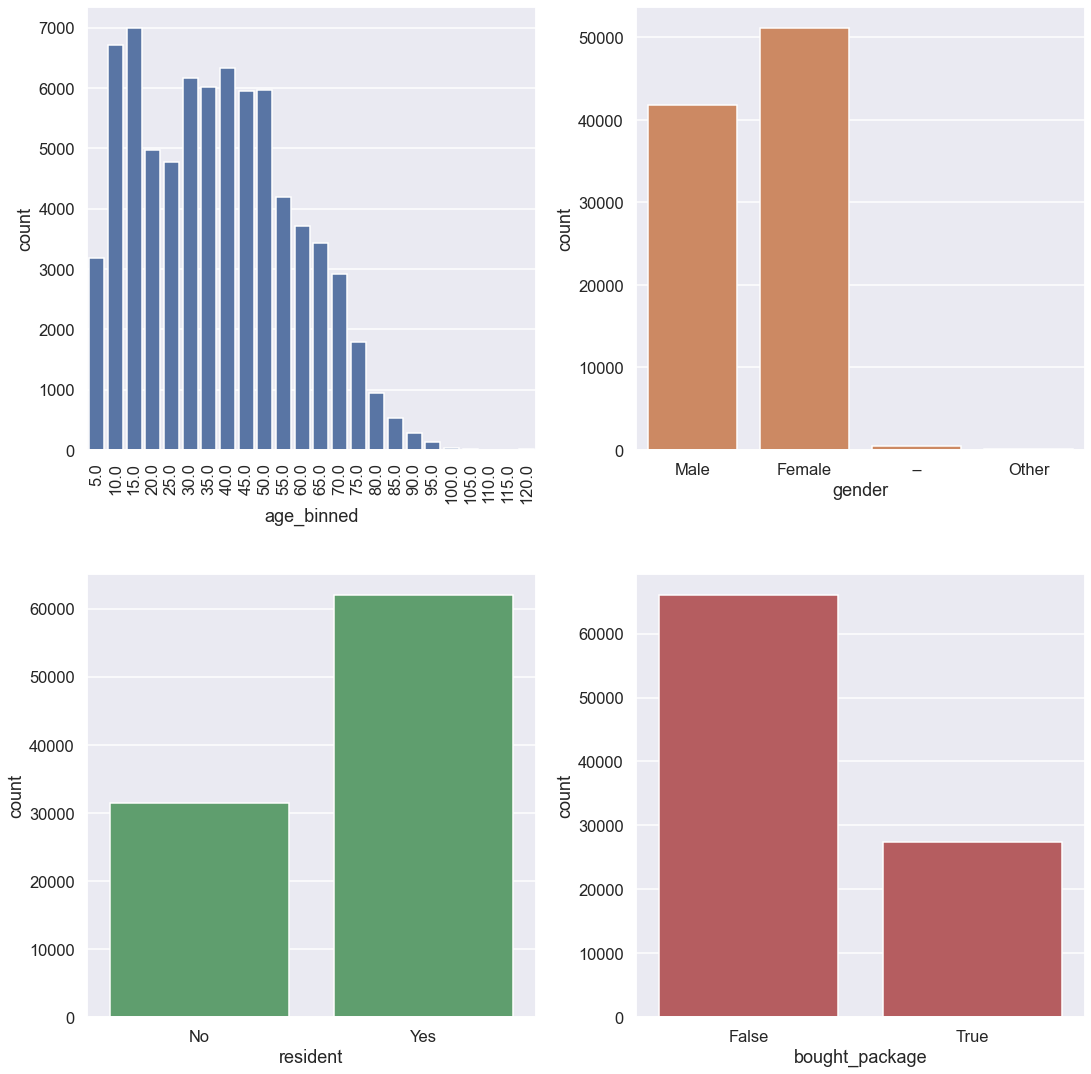

In [24]:
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,16))
f.tight_layout(h_pad=5, pad=3)
axs = ax.flatten()
sns.countplot(data=demo, x='age_binned', color=pal[0], ax=axs[0])
sns.countplot(data=demo, x='gender', color=pal[1], ax=axs[1])
sns.countplot(data=demo, x='resident', color=pal[2], ax=axs[2])
sns.countplot(data=demo, x='bought_package', color=pal[3], ax=axs[3])
axs[0].tick_params(axis='x',rotation=90);

A few insights are already apparent from this cursory view of the dataset:

-  The age range of 15-20 and 20-25 is significantly underrepreseted.  This could represent an opportunity for more customers, if the rec center can add programs and equipment that interest people in those age groups.
  
    
-  Not many customers buy packages - a significant majority pay per-visit instead of buying punchcards/memberships. There could be an opportunity to get the per-visit customers (who likely visit less frequently) more interested and into the membership/punchcard pool.
  
  
- The gender balance is slightly skewed towards women, but generally even.
  
  
- A surprising number of non-residents visit the rec center.  1/3 of customers are tagged non-resident.

Let's look a little deeper into the non-residents.

In [25]:
print("Total number of non-residents:", demo[demo.resident == 'No'].shape[0])
print("\nState breakdown of non-resident customers (top-10):")
demo[demo.resident == 'No']['state'].value_counts().sort_values(ascending=False).head(10)

Total number of non-residents: 31499

State breakdown of non-resident customers (top-10):


CO    30725
CA      116
--      114
TX       53
NY       42
FL       41
AZ       33
WA       29
MA       27
IL       27
Name: state, dtype: int64

In [26]:
print("Total non-resident customers from top-10 cities in Colorado:", demo[(demo.resident == 'No') & (demo.state == 'CO')]['city'].value_counts().sort_values(ascending=False).head(10).sum())
print("\nCity breakdown of non-resident customers from Colorado (top 10):")
demo[(demo.resident == 'No') & (demo.state == 'CO')]['city'].value_counts().sort_values(ascending=False).head(10)

Total non-resident customers from top-10 cities in Colorado: 26583

City breakdown of non-resident customers from Colorado (top 10):


Boulder       11777
Longmont       3406
Louisville     2832
Lafayette      2503
Superior       1411
Broomfield     1145
Denver         1058
Erie            928
Niwot           836
Nederland       687
Name: city, dtype: int64

The high fraction of "non-residents" with `city == 'Boulder` raises the question of what the `city` associated with residents is.  There seem to be some misspellings of Boulder, but not enough to be significant.  Still, we can fix that before moving on.

In [27]:
demo[demo.resident == 'Yes']['city'].value_counts().sort_values(ascending=False).head(10)

Boulder       61637
BOULDER         175
Longmont         38
Louisville       35
Lafayette        31
boulder          24
Niwot            13
--               13
Nederland        13
Golden            9
Name: city, dtype: int64

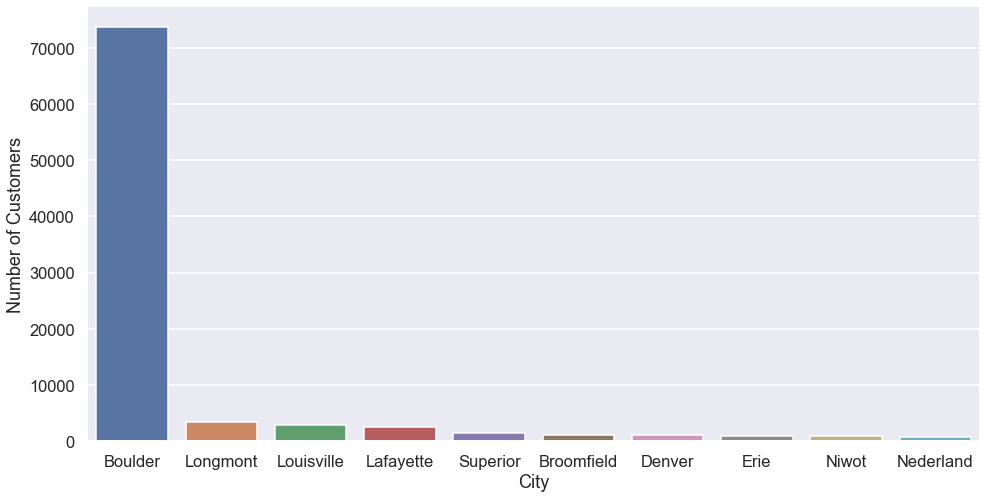

In [28]:
demo['city'] = demo['city'].map(lambda x: x.lower().capitalize())
top10cities = demo['city'].value_counts().sort_values(ascending=False).head(10).index.tolist()
f, ax = plt.subplots(figsize=(16,8))
sns.countplot(data=demo[demo.city.isin(top10cities)], x='city', ax=ax, order=top10cities);
ax.set(ylabel='Number of Customers', xlabel='City');

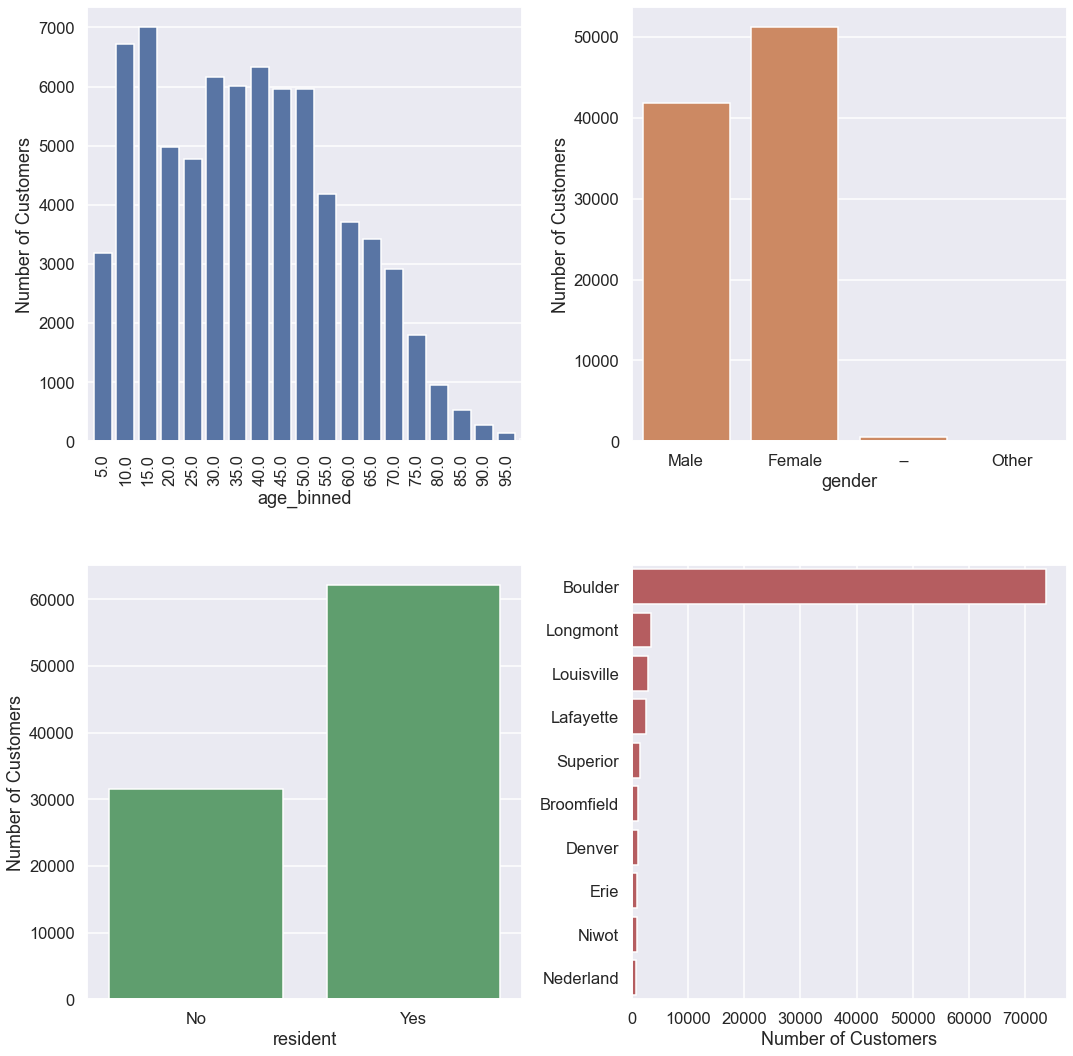

In [29]:
# repeating nice grid above with city instead of bought_package.  better for blog post
f, ax = plt.subplots(ncols=2, nrows=2, figsize=(16,16))
f.tight_layout(h_pad=5, pad=3.5)
axs = ax.flatten()
sns.countplot(data=demo, x='age_binned', color=pal[0], ax=axs[0])
sns.countplot(data=demo, x='gender', color=pal[1], ax=axs[1])
sns.countplot(data=demo, x='resident', color=pal[2], ax=axs[2])
sns.countplot(data=demo[demo.city.isin(top10cities)], y='city', order=top10cities, color=pal[3], ax=axs[3])
axs[0].tick_params(axis='x',rotation=90)
axs[0].set(ylabel='Number of Customers',xlim=[-0.7,18.7])
axs[1].set(ylabel='Number of Customers')
axs[2].set(ylabel='Number of Customers')
axs[3].set(ylabel='', xlabel='Number of Customers');

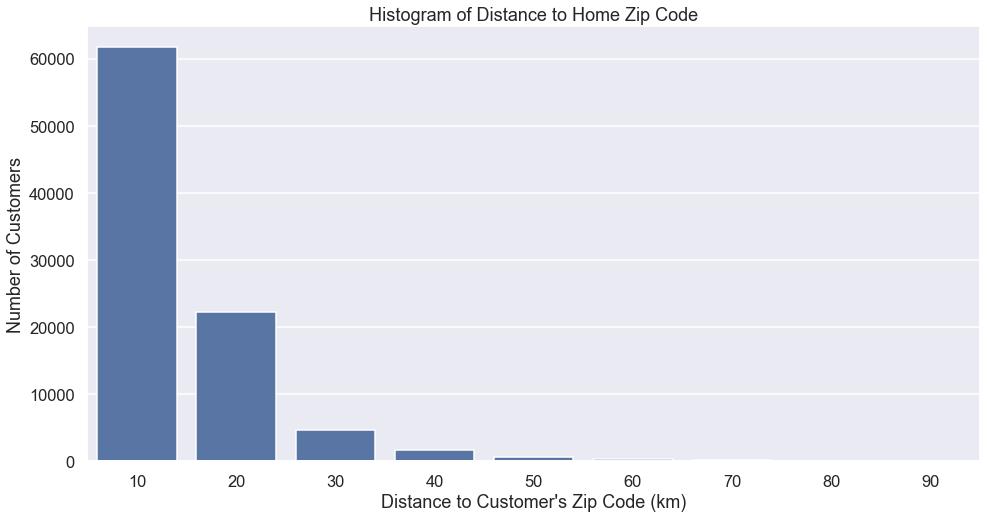

In [30]:
# create bins to bin distance to base zip, up to 100 km
bins=np.arange(0,100,10)
# create associated labels
labels=[str(bin) for bin in bins[1:].tolist()]
# bin the column using pd.cut
demo['distance_binned_km'] = pd.cut(demo['distance_to_base_zip_km'], bins=bins, labels=labels)
f, ax = plt.subplots(figsize=(16,8))
sns.countplot(data=demo, x='distance_binned_km',ax=ax, color=pal[0])
ax.set(ylabel='Number of Customers', xlabel="Distance to Customer's Zip Code (km)",
      title="Histogram of Distance to Home Zip Code");

The vast majority of non-resident customers are from Colorado.  Of those, almost all of them come from either Boulder itself (yet are somehow classified as non-resident) or from the surrounding cities.  Of the top-10 cities, all but Denver are part of the Boulder metro area.  The distance-to-zip code confirms this - there are almost no customers that live more than 50km away from zip code 80310 (Central Boulder).

It appears the non-resident customers are a red herring - the vast majority of customers do indeed come from the Boulder area.  Conversely, the fact that many "resident" customers live in other cities means that the `resident` field is all but meaningless.

Next we can look more into who is buying the packages.  Are some more popular?  Are there differences in popularity between groups?

In [31]:
# Breakdown into people who have bought no package, a punchcard, a membership, or both
conditions = [((demo['Punch']) & (demo['Membership'])),
              (demo['Punch']),
              (demo['Membership'])
             ]
choices = ["Both", "Punch", "Membership"]

demo["PackageType"] = np.select(conditions, choices, default="No Package")

It seems that punch cards are more popular than memberships, and that a small number of customers bought both.  The purchasers of both are likely buying punchcards for a different purpose - a membership for entry, and a punchcard good for 10 Swim Lessons.

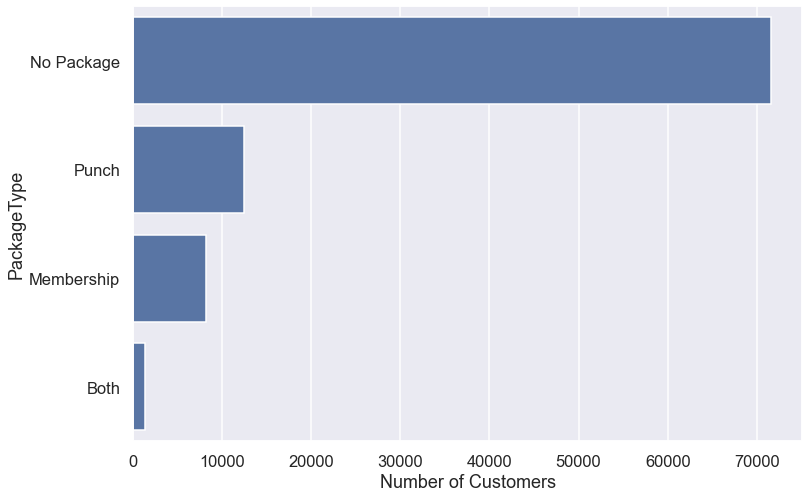

In [32]:
f, ax = plt.subplots(figsize=(12,8))
sns.countplot(data=demo, y='PackageType',order=['No Package','Punch','Membership','Both'],color=pal[0],ax=ax)
ax.set(xlabel='Number of Customers');

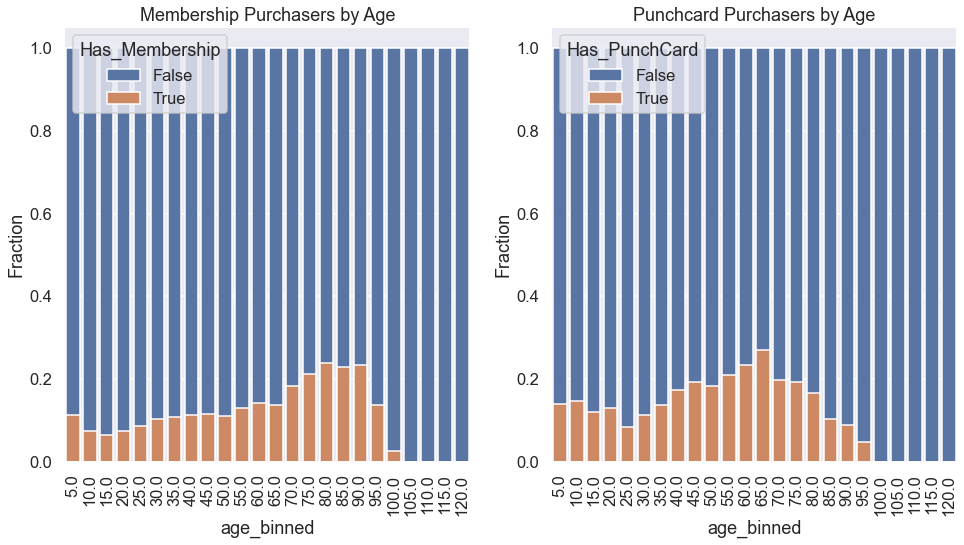

In [33]:
f, ax = plt.subplots(ncols=2,figsize=(16,8))
axs = ax.flatten()
# Create a 100% stacked bar plot.  Neither pandas nor seaborn has this functionality built-in, so it is
# a bit more hacky.  Have to calculate the percentages, then plot those


# first group the data by age and membership and count (ObjectId is just a placeholder)
# then pivot membership into the columns
membership_pct = (demo.groupby(['age_binned','Membership'])['ObjectId']
 .count().reset_index().
 pivot(columns='Membership',values='ObjectId',index='age_binned')
)
# now we can calculate the total number of memberships for each age range
membership_pct['total'] = membership_pct[False] + membership_pct[True]
# seaborn does not actually stack the bars, just plots both of them at the same X value.
# so to get the bar to go to 100% just fill 1 for Membership=False
membership_pct[False] = 1
# calculate the fraction of members who did buy a membership
membership_pct[True] = membership_pct[True] / membership_pct['total']
# finally, bring the dataframe from wide-form back to long-form so it fits seaborn's tidy data worldview
membership_pct = pd.melt(membership_pct.drop(columns=['total']).reset_index(),id_vars=['age_binned'],var_name='Has_Membership',value_name='Pct')
# and, plot
sns.barplot(data=membership_pct,x='age_binned',y='Pct',hue='Has_Membership',dodge=False,ax=ax[0])
ax[0].tick_params(axis='x',rotation=90);

# repeat above process but for punchcards
punch_pct = (demo[demo.age < 95].groupby(['age_binned','Punch'])['ObjectId']
 .count().reset_index().
 pivot(columns='Punch',values='ObjectId',index='age_binned')
)
punch_pct['total'] = punch_pct[False] + punch_pct[True]
punch_pct[False] = 1
punch_pct[True] = punch_pct[True] / punch_pct['total']
punch_pct = pd.melt(punch_pct.drop(columns=['total']).reset_index(),id_vars=['age_binned'],var_name='Has_PunchCard',value_name='Pct')
sns.barplot(data=punch_pct,x='age_binned',y='Pct',hue='Has_PunchCard',dodge=False,ax=ax[1])
ax[1].tick_params(axis='x',rotation=90)
ax[0].set(ylabel='Fraction', title='Membership Purchasers by Age')
ax[1].set(ylabel='Fraction', title='Punchcard Purchasers by Age');

There do seem to be subtle trends in purchasers - customers over 65-70 are more likely to purchase a membership.  This could be due to discounts offered to senior citizens.  Punchcards are generally more popular across the rest of the age range, peaking in the 60-65 age range.  So there are definitely trends in the data.  Analysis across gender reveals that packages are slightly less popular among women than men.

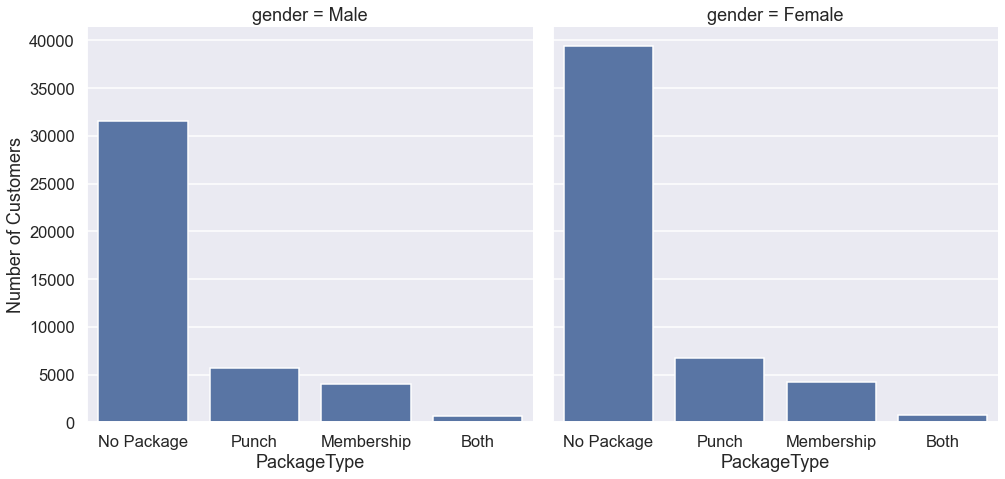

In [34]:
g = sns.FacetGrid(data=demo[demo.gender.isin(['Male', 'Female'])], 
                  col='gender', col_wrap=2, height=7, col_order=['Male', 'Female'])
g.map(sns.countplot,'PackageType', order=['No Package', 'Punch', 'Membership', 'Both']);
g.set_axis_labels('PackageType','Number of Customers');

A final question is around relationships with the time someone has been registered with the rec centers.  Are there trends with gender or package purchase status?

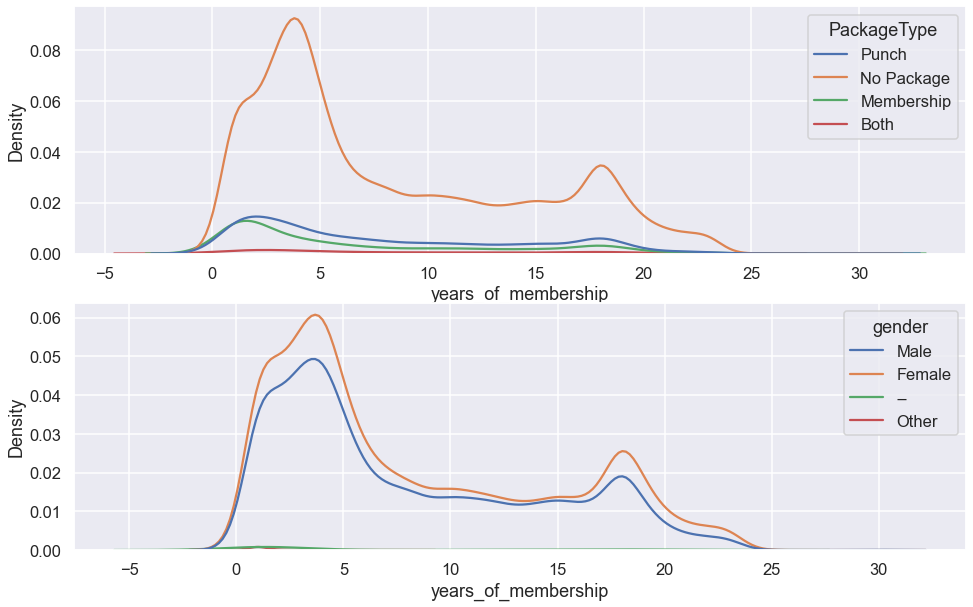

In [35]:
f, axs = plt.subplots(nrows=2, figsize=(16,10))
ax = axs.flatten()
sns.kdeplot(data=demo, hue='PackageType', x='years_of_membership', ax=ax[0], color=pal[0])
sns.kdeplot(data=demo, hue='gender', x='years_of_membership', ax=ax[1], color=pal[1]);

 From the plots below, no clear trends are visible across those elements.  Two bumps around 20 and 3 years of membership are visible in all the distributions, which is a mirror of the bimodal distribution in the `years of membership` in general.  So there does not seem to be a large amount of value in the years of membership.
 
What about the `retired` column?  We know from the data dictionary that it does not refer to 'retired' in the sense of retired from a job.  It refers to whether users are active in the database.  It turns out there are not a significant number of `retired` entries in the dataset.  Essentially all users are active.

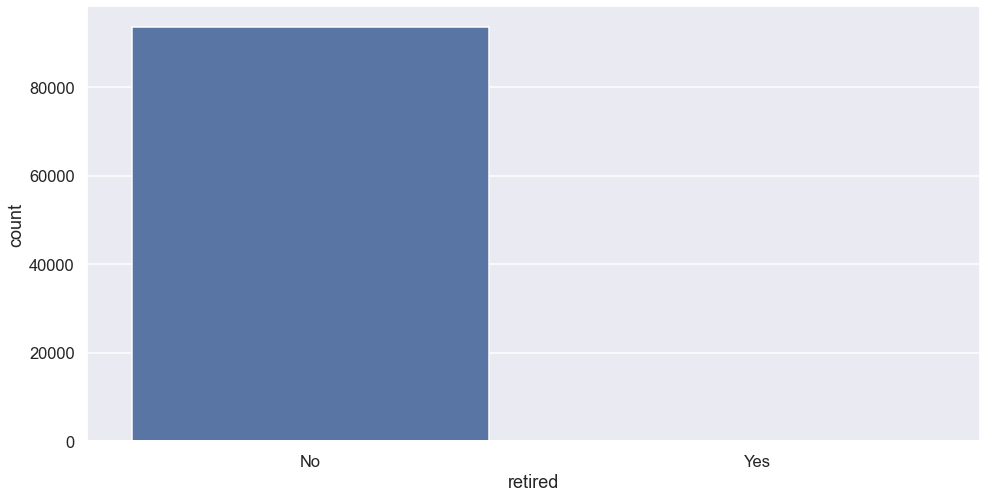

In [36]:
f, ax = plt.subplots(figsize=(16,8))
sns.countplot(data=demo, x='retired');

## Modeling

Is there room for machine learning to be of use here?  The primary use that comes to mind would be in increasing package purchases.  For that, it would be useful to know which type of package to suggest to a customer - should they be given a punchcard or a membership offer?  So a classification model could be useful.

It's notable that because of the relatively low number of features and the skew towards "no package" in the dataset, this will be a challenging task.  The model can achieve a 75% accuracy simply by predicting 'No Package' all the time.  So instead of accuracy we will need to focus more on the precision/recall/f1-score type of metrics.

To begin with, we have to process the data to move it from analysis-suitable to machine-learning-suitable.  Many of these will be in processing and dropping different columns:

`ObjectId`, `retired`, `resident`, `geographic_area_id` will all be dropped completely.  From our analysis, we know that the resident/nonresident distinction in the database is not meaningful, that essentially the entire datset has `retired == 'No'` and `ObjectId` is our unique identifier.

The `PackageXX` columns are effectively our target, and we have already collapsed them into `PackageType` so they will all be dropped.  `zipcode` itself will have too much variation on a categorical variable - upon one-hot encoding it the number of features will explode.  So `zipcode` will be replaced with our calculated `distance_to_base_zip_km` column.  `entrydate` will be replaced with our `years_of_membership` in the ML model.

In [37]:
# drop columns listed in discussion
demo_ml = demo.drop(columns=['ObjectId', 'geographic_area_id', 'zipcode', 'entrydate', 'retired',
                            'Package1', 'Package2', 'Package3', 'Package4', 'Package5', 'Package6',
                             'Package7', 'Packages', 'everything', 'most_things', 'entrymonth', 'Adult',
                             'Senior', 'Family', 'Rez', 'Youth', 'Punch', 'Season', 'bought_package',
                             'age_binned', 'Membership', 'resident', 'distance_binned_km'])
print("After dropping columns, the input to our ML model will be:")
demo_ml.columns.tolist()

After dropping columns, the input to our ML model will be:


['city',
 'state',
 'age',
 'gender',
 'years_of_membership',
 'distance_to_base_zip_km',
 'PackageType']

In [38]:
# Now time to one-hot encode the categorical variables of city/state/gender, and fill missing values in the
# Age and distance_to_base_zip_km features.
demo_ml_dummies = pd.get_dummies(data=demo_ml, columns=['city', 'state', 'gender'], drop_first=True)
X_base = demo_ml_dummies.drop(columns=['PackageType'])
X_imputed = X_base.copy()
# fill missing age values with the average
X_imputed['age'].fillna(X_imputed['age'].mean(), inplace=True)
X_imputed['distance_to_base_zip_km'].fillna(X_imputed['distance_to_base_zip_km'].mean(), inplace=True)
X_imputed.head()

,age,years_of_membership,distance_to_base_zip_km,city_10024,city_Ada,city_Alamosa,city_Albany,city_Alberquerque,city_Albuquerque,city_Allenspark,...,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,gender_Female,gender_Male,gender_Other
0,59.000000,3,14.092344,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,16.000000,14,3.805855,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,35.275194,12,3.805855,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,35.275194,17,3.805855,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,13.000000,12,3.805855,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [39]:
# Now have to encode the targets - use:
# No Package: 0.0
# Punch: 1.0
# Membership: 2.0
# Customers with both punchcard and package are considered to have a membership
conditions = [(demo_ml_dummies['PackageType'] == 'Punch'),
              (demo_ml_dummies['PackageType'] == 'Membership'),
              (demo_ml_dummies['PackageType'] == 'Both')
             ]
choices = [1.0, 2.0, 2.0]

y = np.select(conditions, choices, default=0.0)

With our data fully prepared for machine learning, it is time to create our `train`, `validation` and `test` datasets and then instantiate and fit our models.  To combat the unbalanced nature of our dataset, we will add additional weight to the data points where a customer purchased a package.

The two models tested are AdaBoost and RandomForest, both using default parameters.

In [40]:
# split into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=42)

In [41]:
# instantiate adaboost model
boost = AdaBoostClassifier(random_state=42)
# fit to training data
boost.fit(X_train, y_train, sample_weight=(y_train > 0)*2+1)
# predict validation data
y_valid_pred = boost.predict(X_valid)
# report accuracy and f-scores
boost_acc = accuracy_score(y_valid, y_valid_pred)
print("Accuracy:", boost_acc)
print(classification_report(y_valid, y_valid_pred))

Accuracy: 0.7118837275577088
              precision    recall  f1-score   support

         0.0       0.81      0.87      0.84     13480
         1.0       0.24      0.20      0.22      2307
         2.0       0.25      0.16      0.19      1758

    accuracy                           0.71     17545
   macro avg       0.43      0.41      0.42     17545
weighted avg       0.68      0.71      0.69     17545



In [42]:
# instantiate Random Forest model
forest = RandomForestClassifier(random_state=42)
# fit to training data
forest.fit(X_train,y_train, sample_weight=(y_train > 0)*2+1)
# predict on validation data
y_valid_pred = forest.predict(X_valid)
# report accuracy and f-scores
forest_acc = accuracy_score(y_valid, y_valid_pred)
print("Accuracy:", forest_acc)
print(classification_report(y_valid, y_valid_pred))

Accuracy: 0.6724992875463095
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81     13480
         1.0       0.20      0.19      0.20      2307
         2.0       0.21      0.20      0.20      1758

    accuracy                           0.67     17545
   macro avg       0.41      0.40      0.40     17545
weighted avg       0.66      0.67      0.67     17545



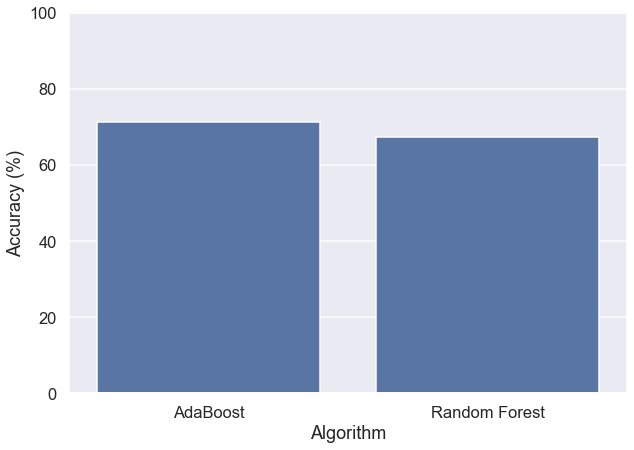

In [43]:
f, ax = plt.subplots(figsize=(10,7))
graph = pd.DataFrame([['AdaBoost', boost_acc*100],
                      ['Random Forest', forest_acc*100]], columns=['Algorithm', 'Accuracy'])
sns.barplot(data=graph, x='Algorithm', y='Accuracy', color=pal[0], ax=ax)
ax.set(ylim=[0,100], ylabel='Accuracy (%)');

In neither situation would we call these models particularly good - their precision for predicting both package types is on the order of 20%, and the recall varies between 25-50%.  However, the bar is not very high in this application.  We are not trying to predict whether fraud is occurring, or whether a patient is likely to have a specific disease.  The application is to inform type of offers email communications or a front desk employee should mention to a specific customer.  Given the minimal cost of an incorrect prediction, models at this level of performance could be quite useful.

In that context, we prefer the AdaBoost model as it provides a similar precision on the different packages with a significantly higher recall.  As a final element of good practice, we will confirm that the performance on the test set matches the validation set with our chosen model.

In [44]:
# repeat for adaboost on test dataset
y_test_pred = boost.predict(X_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84     17857
         1.0       0.26      0.20      0.22      3141
         2.0       0.25      0.15      0.19      2396

    accuracy                           0.71     23394
   macro avg       0.44      0.41      0.42     23394
weighted avg       0.67      0.71      0.69     23394



As a demonstration or sense check, it can help to see if the model faithfully recreates trends observed by exploratory data analysis.  To that end, we can predict the probability of each package purchase across the age range and see if it matches what we saw in our data analysis.

In [45]:
# build a group of entries to feed to the model as a sanity check
# set all data to zero initially
X_model_test = pd.DataFrame(np.zeros((95,X_test.shape[1])), columns=X_test.columns)
# age from 1-95
X_model_test['age'] = np.arange(1,96)
# average years of membership
X_model_test['years_of_membership'] = X_test['years_of_membership'].mean()
# average distance to zip for users from boulder
X_model_test['distance_to_base_zip_km'] = demo_ml[demo_ml.city == 'Boulder']['distance_to_base_zip_km'].mean()
# add one-hot encoding for person being a woman from Boulder, CO
X_model_test['city_Boulder'] = 1
X_model_test['state_CO'] = 1
X_model_test['gender_Female'] = 1

In [46]:
# predict based on sanity chec
y_model_test = boost.predict_proba(X_model_test)

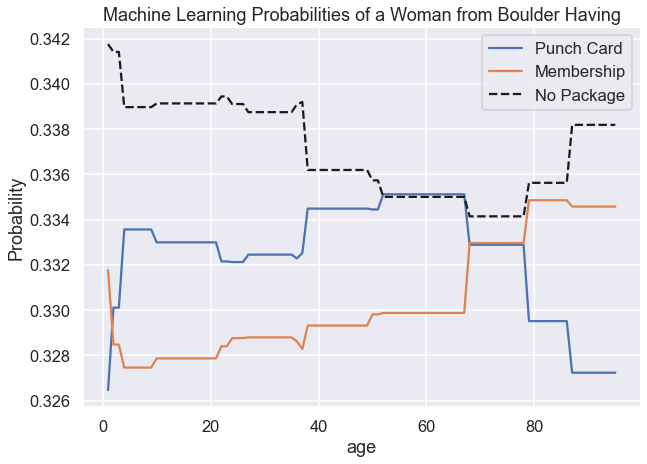

In [47]:
# plot predictions
f, ax = plt.subplots(figsize=(10,7))
ax.plot(X_model_test['age'], y_model_test[:,1], color=pal[0], label='Punch Card')
ax.plot(X_model_test['age'], y_model_test[:,2], color=pal[1], label='Membership')
ax.plot(X_model_test['age'], y_model_test[:,0], color='k', ls='--', label='No Package')
ax.set(ylabel='Probability', xlabel='age', title='Machine Learning Probabilities of a Woman from Boulder Having')
ax.legend();

Looks good, the trends of popularity of memberships and punch cards vs age closely match our prior observations.  We can do the same with our observation that packages are less popular for women.

In [48]:
# duplicate previous sanity check data
temp = X_model_test.copy()
# switch gender of hypothetical customers from Female to Male
temp['gender_Female'] = 0
temp['gender_Male'] = 1
# bring the two datasets together so we have the same test info for Males and Females
X_model_test_2 = pd.concat([X_model_test.copy(),temp.copy()]).reset_index().drop(columns='index')
# predict on sanity check data and turn to dataframe
y_model_test_2 = pd.DataFrame(boost.predict_proba(X_model_test_2), 
                              columns=['No Package','Punch Card', 'Membership'])
# bring model input and output together
model_test_2 = pd.concat([X_model_test_2, y_model_test_2], axis=1)
# make input more plotting-friendly
model_test_2['PackagePurchaseProb'] = 1 - model_test_2['No Package']
model_test_2['gender'] = model_test_2['gender_Female'].map(lambda x: 'Female' if x==1 else 'Male')

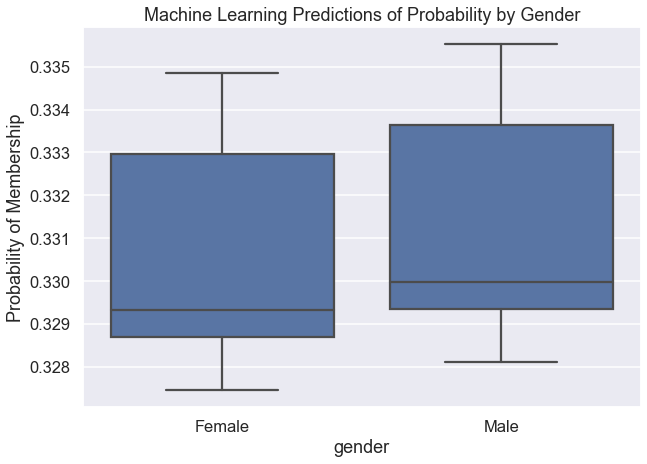

In [49]:
# plot results for female vs male comparison in the model
f, ax = plt.subplots(figsize=(10,7))
sns.boxplot(data=model_test_2, x='gender', y='Membership', ax=ax, color=pal[0])
ax.set(xlabel='gender', 
       ylabel='Probability of Membership', 
       title='Machine Learning Predictions of Probability by Gender');

The model also predicts a slightly lower membership-purchase probability for women than men, matching our observations in the data.

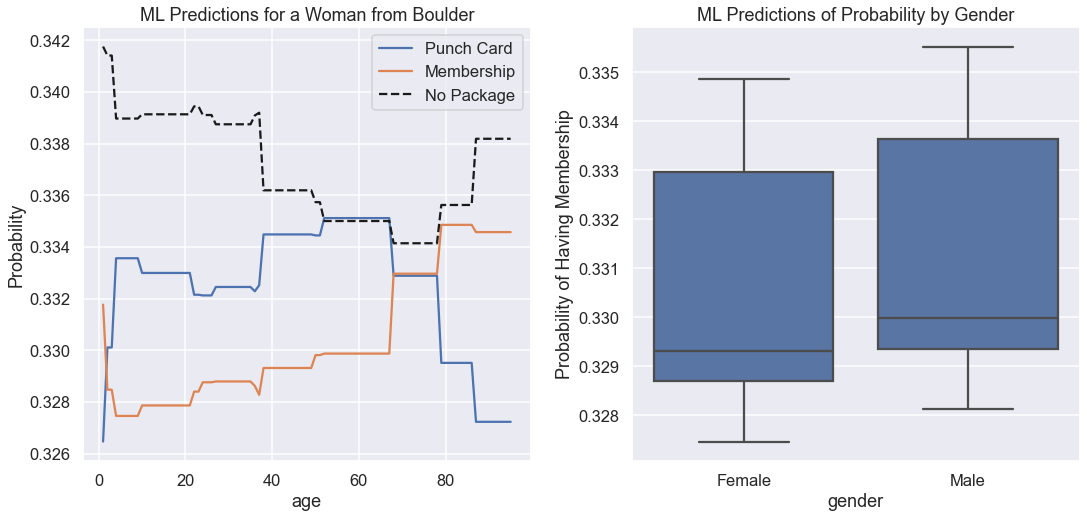

In [50]:
f, ax = plt.subplots(ncols=2, figsize=(16,8))
f.tight_layout(pad=3)
ax=ax.flatten()
ax[0].plot(X_model_test['age'], y_model_test[:,1], color=pal[0], label='Punch Card')
ax[0].plot(X_model_test['age'], y_model_test[:,2], color=pal[1], label='Membership')
ax[0].plot(X_model_test['age'], y_model_test[:,0], color='k', ls='--', label='No Package')
ax[0].set(ylabel='Probability', xlabel='age', title='ML Predictions for a Woman from Boulder')
ax[0].legend();
sns.boxplot(data=model_test_2, x='gender', y='Membership', ax=ax[1], color=pal[0])
ax[1].set(xlabel='gender', ylabel='Probability of Having Membership', title='ML Predictions of Probability by Gender');